### 필수과제 2
- 이진분류할 데이터를 가지고 필수과제 1에서 서칭한 파라미터들을 튜닝하면서 모델링을 진행하기
- 데이터 전처리 방식 정리하기
- 실제 데이터 전처리를 최소 2~3개정도 다르게 진행해 보시면서 (변수를 빼거나 할 수 있음) 실제 값이 얼마나 차이가 나는지 확인하기

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [33]:
movie = pd.read_csv("movie_rv.csv", encoding = 'utf-8')
columns = ['id','document','label']
movie = movie[columns]
movie.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [34]:
# 데이터 중복 확인 및 제거
print('총 영화 리뷰 수 :',len(movie))
movie.drop_duplicates(subset = ['document'], inplace = True)
print('중복 리뷰 수 :',150000 - len(movie))
print('제거된 후 영화 리뷰 수 :',len(movie))

총 영화 리뷰 수 : 150000
중복 리뷰 수 : 3817
제거된 후 영화 리뷰 수 : 146183


각 라벨의 수
0    73342
1    72841
Name: label, dtype: int64
----------------------------------------------------------------------


<Axes: >

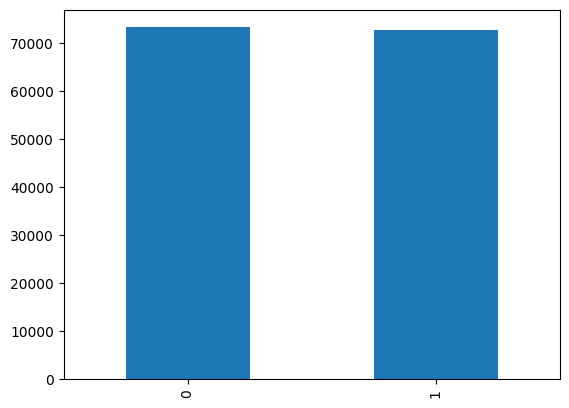

In [35]:
# label 분포 확인
print('각 라벨의 수')
print(movie['label'].value_counts())
print("-"*70)
movie['label'].value_counts().plot(kind='bar')

In [36]:
# 결측치 확인
movie.isnull().sum()
# 결측치 리뷰 1개 발견, 영향이 크게 있지 않을 것이라 판단하고 제거

id          0
document    1
label       0
dtype: int64

In [37]:
# 결측치 제거
movie.dropna(how = 'any', inplace = True)
print(movie.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [38]:
# 한글과 공백을 제외한 특수문자 제거
movie['document'] = movie['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
movie.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [51]:
# 리뷰가 없는 데이터 확인
movie['document'] = movie['document'].str.replace('^ +', "")
movie['document'].replace('', np.nan, inplace=True)
print(movie.isnull().sum())

id            0
document    391
label         0
dtype: int64


In [52]:
# 리뷰 없는 데이터 제거
movie.dropna(how = 'any', inplace = True)
print(movie.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [40]:
# 불용어 지정
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [47]:
# 단어 토큰화 위한 형태소 분석기 사용(Okt)
!pip install konlpy
from konlpy.tag import Okt
okt = Okt()

In [54]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(movie['document'],movie['label'], test_size = 0.3)
print(len(X_train), len(X_test),len(y_train), len(y_test))

102053 43738 102053 43738


In [58]:
from tqdm import tqdm
train = []
for sentence in tqdm(X_train):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    train.append(stopwords_removed_sentence)

100%|██████████| 102053/102053 [07:06<00:00, 239.32it/s]


In [59]:
test = []
for sentence in tqdm(X_test):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    test.append(stopwords_removed_sentence)

100%|██████████| 43738/43738 [03:07<00:00, 233.27it/s]


In [61]:
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train)

In [62]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '되다': 11, '재밌다': 12, '적': 13, '만': 14, '같다': 15, '진짜': 16, '로': 17, '않다': 18, '아니다': 19, '점': 20, '에서': 21, '만들다': 22, '것': 23, '나오다': 24, '평점': 25, '연기': 26, '내': 27, '최고': 28, '그': 29, '나': 30, '인': 31, '안': 32, '생각': 33, '못': 34, '스토리': 35, '왜': 36, '드라마': 37, '게': 38, '감동': 39, '사람': 40, '보고': 41, '말': 42, '이렇다': 43, '아깝다': 44, '고': 45, '더': 46, 'ㅋㅋ': 47, '때': 48, '배우': 49, '감독': 50, '재미있다': 51, '거': 52, '아': 53, '요': 54, '그냥': 55, '시간': 56, '내용': 57, '재미': 58, '뭐': 59, '중': 60, '주다': 61, '자다': 62, '까지': 63, '하고': 64, '지루하다': 65, '수': 66, '재미없다': 67, '쓰레기': 68, '네': 69, '들다': 70, '모르다': 71, '가다': 72, '싶다': 73, '그렇다': 74, '지': 75, '사랑': 76, '작품': 77, '알다': 78, '하나': 79, '다시': 80, '볼': 81, '마지막': 82, '이건': 83, '정도': 84, '저': 85, '완전': 86, 'ㅋ': 87, '오다': 88, 'ㅠㅠ': 89, 'ㅋㅋㅋ': 90, '처음': 91, '많다': 92, '장면': 93, '주인공': 94, '액션': 95, '걸': 96, '차다': 97, '안되다': 98, '개': 99, '이렇게': 100, '나다': 101, '돈': 1

In [63]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 37395
등장 빈도가 2번 이하인 희귀 단어의 수: 21133
단어 집합에서 희귀 단어의 비율: 56.51290279449124
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.3340972142775427


In [64]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 16263


In [67]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(train)
X_train = tokenizer.texts_to_sequences(train)
X_test = tokenizer.texts_to_sequences(test)

In [68]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [69]:
# 낮은 빈도수 제거 후 빈 샘플이 된 데이터 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [70]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

101590
101590


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.756304754404962


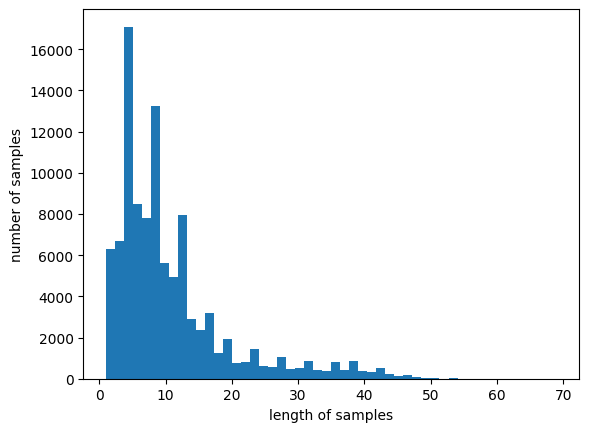

In [71]:
# 패딩 통해 샘플 길이 동일하게 맞추기
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [72]:
# 전체 샘플 중 길이가 max_len이하인 샘플 비율
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [73]:
# max_len을 30으로 설정 -> 약 94%의 리뷰가 30이하의 길이를 가짐
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.40988286248646


In [74]:
# 모든 샘플의 길이를 패딩을 통해 30으로 고정
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [75]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

#정확도, Roc 측정
print(accuracy_score(y_test,lr_preds), '정확도')
print(roc_auc_score(y_test,lr_preds), 'roc')

0.5117289313640313 정확도
0.5109907176868538 roc


In [76]:
solvers = ['lbfgs','liblinear','newton-cg','sag','saga']

for solver in solvers:
    lr_clf = LogisticRegression(solver = solver, max_iter = 800)
    lr_clf.fit(X_train, y_train)
    lr_preds = lr_clf.predict(X_test)

    print('solver:{0}, accuracy:{1:.3f}, roc_auc:{2:.3f}'.format(solver, accuracy_score(y_test, lr_preds),
                                                                roc_auc_score(y_test, lr_preds)))

solver:lbfgs, accuracy:0.512, roc_auc:0.511
solver:liblinear, accuracy:0.520, roc_auc:0.520
solver:newton-cg, accuracy:0.520, roc_auc:0.520
solver:sag, accuracy:0.512, roc_auc:0.511
solver:saga, accuracy:0.512, roc_auc:0.511


In [77]:
def log_tuning(train, y, params):
    lr_clf = LogisticRegression(random_state=111)
    grid = GridSearchCV(lr_clf, params, scoring='roc_auc',cv =7)
    grid.fit(train,y)

    print('best parms :',grid.best_params_)
    print('best score :',grid.best_score_)

    return grid.best_estimator_

In [78]:
param = {'penalty':['l2'], 'C':[0.1,0.2,0.3,0.5, 1, 5, 10], 'max_iter':[100,200,300,400,500,700]}
log_tuning(X_train, y_train, params= param)

best parms : {'C': 0.1, 'max_iter': 100, 'penalty': 'l2'}
best score : 0.5322598609816694


LogisticRegression(C=0.1, random_state=111)